# Generating saliency maps for neural networks trained on L96

In this notebook, we explore techniques for generating saliency maps, a common approach for attempting to interpret the inner workings of deep neural networks [[1](https://arxiv.org/pdf/1312.6034.pdf),[2](https://www.jmlr.org/papers/volume11/baehrens10a/baehrens10a.pdf),[3](https://proceedings.neurips.cc/paper/2018/file/294a8ed24b1ad22ec2e7efea049b8737-Paper.pdf)].

## Load dependencies

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from torch.autograd import Variable, grad
from torch.autograd.functional import jacobian
import torch.nn.functional as F
import torch.utils.data as Data
from torch import nn, optim
import torch.nn.functional as F

from sklearn.metrics import r2_score
np.random.seed(14) # For reproducibility 
torch.manual_seed(14) # For reproducibility 

## Generate L96 data

In [2]:
from L96_model_XYtend import L96, L96_eq1_xdot, integrate_L96_2t  # L96_model_XYtend Adds the option to ouptput the subgrid tendencies (effect of Y on X)
from L96_model_XYtend import EulerFwd, RK2, RK4 

In [3]:
time_steps = 20000
Forcing, dt, T = 18, 0.01, 0.01*time_steps

# Create a "synthetic world" with K=8 and J=32
K = 8
J = 32
W = L96(K, J, F=Forcing)
# Get training data for the neural network. 

#- Run the true state and output subgrid tendencies (the effect of Y on X is xytrue):
Xtrue,_,_,xytrue = W.run(dt, T,store=True)

## Load a pretrained neural network

In [4]:
# Specify a path
PATH = "../04Subgrid-parametrization-pytorch/networks/network_3_layers_100_epoches.pth"
# Load
weights = torch.load(PATH)
weights.keys()

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])

In [12]:
class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16) # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16) # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs
#         self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting. 

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    
model = Net_ANN()
model.load_state_dict(weights)
model.eval()

Net_ANN(
  (linear1): Linear(in_features=8, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=8, bias=True)
)

## Generate saliency maps using input gradients

Since neural networks are differentiable, the simplest way of generating saliency maps (i.e. a quantification of the sensitivity of the output to the input) is to just take its first derivative with respect to its inputs (or Jacobian, for networks with multiple inputs and outputs).

We can do this easily in Pytorch using `torch.autograd.functional.jacobian`:

In [28]:
%%time
jacobians = np.array([
  jacobian(model, torch.tensor(np.single(Xtrue[i,:]), requires_grad=True)).detach().numpy()
    for i in range(200)
])

CPU times: user 226 ms, sys: 2.94 ms, total: 229 ms
Wall time: 229 ms


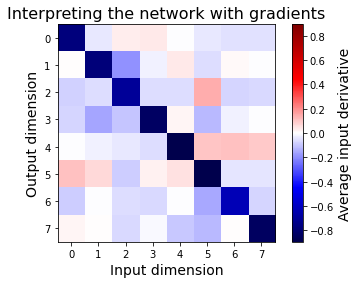

In [74]:
def imshow(x, colorbar_pct=97.5, cmap='seismic', **kw):
    vlim = np.percentile(np.abs(x), colorbar_pct)
    return plt.imshow(x, vmin=-vlim, vmax=vlim, cmap=cmap, **kw)

plt.title("Interpreting the network with gradients", fontsize=16)
imshow(jacobians.mean(0))
plt.colorbar().set_label("Average input derivative", fontsize=14)
plt.xticks(range(8))
plt.yticks(range(8))
plt.xlabel("Input dimension", fontsize=14)
plt.ylabel("Output dimension", fontsize=14)
plt.show()

As might be expected from the equations, the dominant term in the gradient is close to -1 along the main diagonal, but there are significant off-diagonal elements.

Although computing full Jacobians works fine for a small example, it can become expensive for large networks and input/output dimensions, so we can also approximate it using finite differences:

In [64]:
%%time
epsilon = 1e-2
approx_jacobians = []

for case in (range(200)):
    inputs = np.copy(Xtrue[case,:])
    # estimate dy/dx = (y(x+epsilon)-y(x))/epsilon
    # TODO need to perturb every components
    inputs = torch.tensor(np.single(inputs), requires_grad = False)
    pred = model(inputs)
    Js = np.zeros((len(inputs),len(pred)))
    for j in range(len(inputs)):
        perturb = np.single(np.zeros(np.shape(inputs)))
        perturb[j] = epsilon
        perturb = perturb#*std_vec # percent change
        Js[j,:] = ( model(torch.tensor(inputs+perturb))-model(inputs) ).detach().numpy() /(np.sum(perturb))
    approx_jacobians.append(Js.T)

approx_jacobians = np.array(approx_jacobians)

<timed exec>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


CPU times: user 349 ms, sys: 2.74 ms, total: 352 ms
Wall time: 351 ms


(Technically this is slightly slower than the previous example, but it can be more performant for large networks.)

Let's see how that looks:

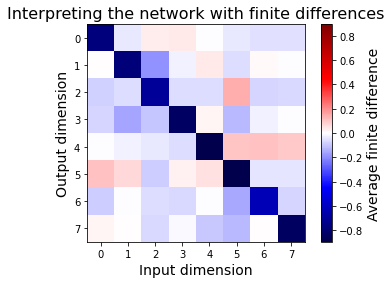

In [75]:
plt.title("Interpreting the network with finite differences", fontsize=16)
imshow(approx_jacobians.mean(0))
plt.colorbar().set_label("Average finite difference", fontsize=14)
plt.xticks(range(8))
plt.yticks(range(8))
plt.xlabel("Input dimension", fontsize=14)
plt.ylabel("Output dimension", fontsize=14)
plt.show()

As expected, it's fairly similar to the full Jacobian method.

## Generate saliency maps layerwise relevance propagation (LRP)

Another proposed method for generating saliency maps is [layerwise relevance propagation](https://doi.org/10.1371/journal.pone.0130140). With a baseline of 0, this method is akin to multiplying the input gradients by the input itself (per [Ancona et al. 2016](https://arxiv.org/pdf/1711.06104.pdf)), but it has become popular in the climate community and does support alternative baselines.

In [66]:
for name in weights.keys():
    print (name)

linear1.weight
linear1.bias
linear2.weight
linear2.bias
linear3.weight
linear3.bias


In [67]:
epsilon = 0.0  # filtering small values
gamma   = 0.0  # give more weights to positive values

## get the weight and bias of the NN
def get_weight(weightsname):
    Ws = []
    Bs = []
    for (i,name) in enumerate (weights.keys()):
        if i %2 ==0:
            Ws.append(np.array(weights[name]))
        else: Bs.append(np.array(weights[name]))
    return Ws,Bs # weights and biases

# forward pass to calculate the output of each layer
def forward_pass(data,Ws,Bs):
    L = len(Ws)                  
    forward = [data]+[None]*L

    for l in range(L-1):
        forward[l+1] = np.maximum(0,Ws[l].dot(forward[l])) + Bs[l] # ativation ReLu

    ## for last layer that does not have activation function
    forward[L] = Ws[L-1].dot(forward[L-1]) + Bs[L-1] # linear last layer
    return forward

def rho(w,l):  
    w_intermediate =  w + [0.0,0.0,0.0,0.0,0.0][l] * np.maximum(0,w)
    return w_intermediate + gamma*np.maximum(0,w_intermediate)

def incr(z,l): return z + [0.0,0.0,0.0,0.0,0.0][l] * (z**2).mean()**.5+1e-9

## backward pass to compute the LRP of each layer. Same rule applied to the first layer (input layer)
def onelayer_LRP(W,B,forward,nz,zz): 
    mask = np.zeros((nz))
    mask[zz] = 1 
    L = len(W)
    R = [None]*L + [forward[L]*mask] # start from last layer Relevance

    for l in range(0,L)[::-1]:
        w = rho(W[l],l)
        b = rho(B[l],l)
        z = incr(w.dot(forward[l])+b + epsilon,l)        # step 1 - forward pass
        s = np.array(R[l+1]) / np.array(z)               # step 2 - element-wise division
        c = w.T.dot(s)                                   # step 3 - backward pass
        R[l] = forward[l]*c                              # step 4 - element-wise product
    return R

def LRP_alllayer(data, weights):
    """inputs: 
            data: for single sample, with the right asix, the shape is (nz,naxis)
            weights: dictionary of weights and biases
        output: 
            LRP, shape: (nx,L+1) that each of the column consist of L+1 array
            Relevance of fisrt layer's pixels """
    nx = data.shape[0]
    ## step 1: get the wieghts
    Ws, Bs = get_weight(weights)
    
    ## step 2: call the forward pass to get the intermediate layers output
    inter_layer = forward_pass(data,Ws,Bs)
    
    ## loop over all z and get the LRP of each layer
    R_all = [None]*nx
    relevance = np.zeros((nx,nx))
    for xx in range(nx):
        R_all[xx] = onelayer_LRP(Ws,Bs,inter_layer,nx,xx)
        relevance[xx,:] = R_all[xx][0]
    
    return np.stack(R_all),relevance

In [86]:
%%time
R_many = []
for case in (range(200)):
    inputs = np.copy(Xtrue[case,:])
    _,Rs  = LRP_alllayer(inputs,weights)
    R_many.append(Rs)
LRP = np.stack(R_many)

CPU times: user 178 ms, sys: 4.54 ms, total: 183 ms
Wall time: 182 ms


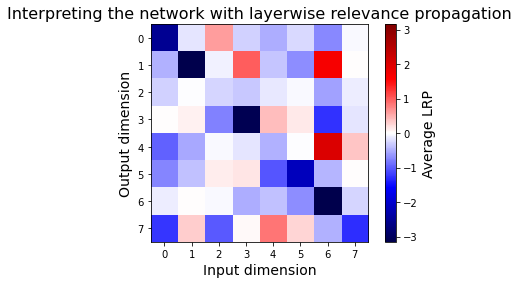

In [87]:
plt.title("Interpreting the network with layerwise relevance propagation", fontsize=16)
imshow(LRP.mean(0))
plt.colorbar().set_label("Average LRP", fontsize=14)
plt.xticks(range(8))
plt.yticks(range(8))
plt.xlabel("Input dimension", fontsize=14)
plt.ylabel("Output dimension", fontsize=14)
plt.show()

LRP outputs something qualitatively different from the gradient-based methods, and in fact each element should be interpreted more as an attribution score (i.e. the actual contribution of an input to the output) than as a sensitivity score (i.e. how much an output changes with an input). Below, we'll see that this approximately reduces to multiplying the gradient by the input.

## Comparing all of the methods

Let's look at the output of these methods side-by-side:

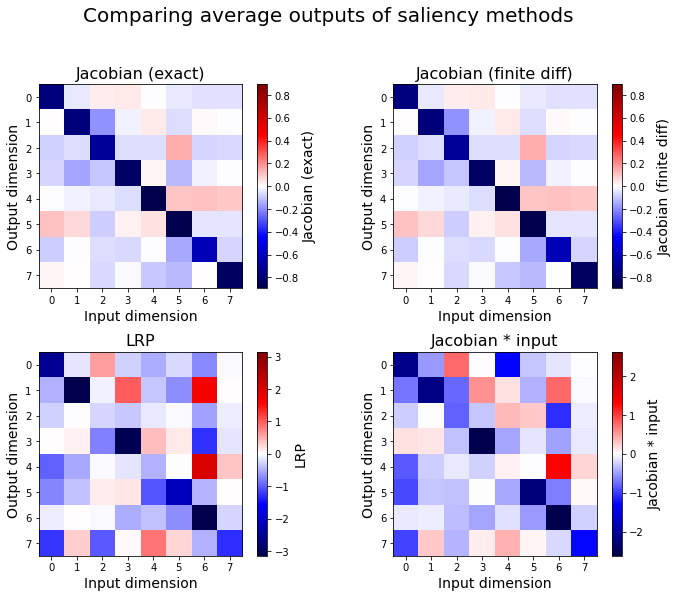

In [93]:
comparisons = [
    (jacobians, "Jacobian (exact)"),
    (approx_jacobians, "Jacobian (finite diff)"),
    (LRP, "LRP"),
    (jacobians * Xtrue[:200][:,np.newaxis,:], "Jacobian * input")
]

fig = plt.figure(figsize=(10,8))
fig.suptitle("Comparing average outputs of saliency methods", fontsize=20, y=1.0, va='bottom')

for i, (saliency, label) in enumerate(comparisons):
    plt.subplot(2, 2, i+1)
    plt.title(label, fontsize=16)
    imshow(saliency.mean(0))
    plt.colorbar().set_label(label, fontsize=14)
    plt.xticks(range(8))
    plt.yticks(range(8))
    plt.xlabel("Input dimension", fontsize=14)
    plt.ylabel("Output dimension", fontsize=14)
    
plt.tight_layout()
plt.show()

As expected, LRP and Jacobian * input produce very similar outputs. For more information on the intricacies of saliency maps, see [Ancona et al. 2018](https://arxiv.org/pdf/1711.06104.pdf) and [Adebayo et al. 2018](https://proceedings.neurips.cc/paper/2018/file/294a8ed24b1ad22ec2e7efea049b8737-Paper.pdf).